# Model Error Category Analysis
This notebook analyzes the error categories for each model across all steps to help understand common failure modes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast
from matplotlib.backends.backend_pdf import PdfPages

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Load data
df = pd.read_csv('/global/cfs/projectdirs/atlas/joshua/llm4hep/results_summary.csv', comment='#')

# Remove rows with missing supervisor or coder
df = df.dropna(subset=['supervisor', 'coder'])

print(f"Total records: {len(df)}")
print(f"Successful trials: {len(df[df['success'] == True])}")
print(f"Failed trials: {len(df[df['success'] == False])}")
print(f"Success rate: {len(df[df['success'] == True]) / len(df) * 100:.1f}%")

Total records: 1484
Successful trials: 875
Failed trials: 609
Success rate: 59.0%


## Parse Error Categories

In [14]:
# Model name mapping (same as in five_step_analysis.ipynb)
# Dates reflect actual underlying model versions discovered via API testing
MODEL_NAME_MAPPING = {
    # Anthropic Claude models (with version dates from API testing)
    'anthropic/claude-haiku:latest': 'Claude Haiku 4.5 (2025-10-01)',  # claude-haiku-4-5@20251001
    'anthropic/claude-opus:latest': 'Claude Opus 4.1 (2025-08-05)',   # us.anthropic.claude-opus-4-1-20250805-v1:0
    'anthropic/claude-sonnet:latest': 'Claude Sonnet 4.5 (2025-09-29)', # claude-sonnet-4-5@20250929
    'claude-3-5-haiku-latest': 'Claude 3.5 Haiku (2024-10-22)',        # claude-3-5-haiku@20241022
    
    # Google Gemini (from CBORG mapping test)
    'google/gemini:latest': 'Gemini 2.5 Pro',          # gemini-2.5-pro
    'google/gemini-flash': 'Gemini 2.5 Flash',         # gemini-2.5-flash
    'gemini-2.0-flash-lite': 'Gemini 2.0 Flash Lite',  # (no alias)
    
    # OpenAI models (with version dates from API testing)
    # Note: openai/o:latest and openai/o3 both map to azure/o3-2025-04-16 (same model, merged in plots)
    'openai/o:latest': 'O3 (2025-04-16)',       # azure/o3-2025-04-16 (aliased)
    'openai/gpt-5': 'GPT-5 (2025-08-07)',       # gpt-5-2025-08-07
    'openai/gpt-5-mini': 'GPT-5 Mini (2025-08-07)', # gpt-5-mini-2025-08-07
    'openai/o3': 'O3 (2025-04-16)',             # azure/o3-2025-04-16 (direct, same as o:latest)
    'openai/o3-mini': 'O3 Mini (2025-01-31)',   # azure/o3-mini-2025-01-31
    'openai/o4-mini': 'O4 Mini (2025-04-16)',   # azure/o4-mini-2025-04-16
    
    # xAI Grok (from CBORG mapping test)
    'xai/grok:latest': 'Grok-3',                # grok-3
    'xai/grok-mini': 'Grok Mini',               # Rate limited during test
    'xai/grok-code-fast-1': 'Grok Code Fast 1', # Rate limited during test
    
    # AWS models (with version info from API testing)
    'aws/llama-4-maverick': 'Llama-4 Maverick (17B)',  # us.meta.llama4-maverick-17b-instruct-v1:0
    'aws/llama-4-scout': 'Llama-4 Scout (17B)',        # us.meta.llama4-scout-17b-instruct-v1:0
    
    # Other models (with version info where available)
    'gpt-oss-120b': 'GPT-OSS-120B',     # hosted_vllm/hosted_vllm/gpt-oss-120b
    'gpt-5-codex': 'GPT-5 Codex',       # Model not accessible during test
    'deepseek-r1': 'DeepSeek-R1',       # MAI-DS-R1
    'gcp/qwen-3': 'Qwen-3 (235B)',      # qwen/qwen3-235b-a22b-instruct-2507-maas
}

def resolve_model_name(model_alias):
    """Convert CBORG alias to display name."""
    if pd.isna(model_alias):
        return model_alias
    model_str = str(model_alias).strip()
    return MODEL_NAME_MAPPING.get(model_str, model_str)

def create_pair_label(row):
    supervisor = resolve_model_name(row['supervisor'])
    coder = resolve_model_name(row['coder'])
    if supervisor == coder:
        return supervisor
    else:
        return supervisor + ' / ' + coder

df['model'] = df.apply(create_pair_label, axis=1)

# Parse error column
def parse_errors(error_value):
    """Parse error value which can be a list or string."""
    if pd.isna(error_value):
        return []
    
    try:
        # Try to evaluate as Python literal (list)
        errors = ast.literal_eval(str(error_value))
        if isinstance(errors, list):
            return errors
        else:
            return [str(errors)]
    except:
        # If parsing fails, treat as string
        return [str(error_value)]

def normalize_error_name(error_str):
    """Normalize error names for better readability."""
    if pd.isna(error_str):
        return 'unknown'
    
    error_str = str(error_str).strip()
    
    # Normalize specific error types
    if error_str == 'all data weights = 0, dummy data created':
        return 'all data weights = 0'
    elif error_str == 'uncategorized':
        return 'OpenAI API error'
    
    # Return as-is for other errors
    return error_str

df['error_list'] = df['Error'].apply(parse_errors)

# Explode the error list so each error type gets its own row
df_errors = df.explode('error_list')

# Clean up error names, handle NaN, and normalize for clarity
df_errors['error_type'] = df_errors['error_list'].apply(normalize_error_name)

# Filter out empty errors
df_errors = df_errors[df_errors['error_type'] != ''].copy()

print(f"\nUnique error types found:")
for err in sorted([e for e in df_errors['error_type'].unique() if e]):
    count = len(df_errors[df_errors['error_type'] == err])
    print(f"  {err}: {count}")


Unique error types found:
  OpenAI API error: 98
  all data weights = 0: 2
  dummy data created: 1
  function-calling error: 193
  incorrect branch name: 22
  intermediate file not found: 90
  other: 544
  semantic error: 534
  unknown: 1


## Error Distribution by Model

In [15]:
# Count errors by model and type
error_counts = df_errors.groupby(['model', 'error_type']).size().reset_index(name='count')

# Also get total trials per model for context
total_trials = df.groupby('model').size().reset_index(name='total_trials')
failed_trials = df[df['success'] == False].groupby('model').size().reset_index(name='failed_trials')

# Merge
model_stats = total_trials.merge(failed_trials, on='model', how='left').fillna(0)
model_stats['success_rate'] = ((model_stats['total_trials'] - model_stats['failed_trials']) / 
                                model_stats['total_trials'] * 100)

print("\nModel Statistics:")
print(model_stats.sort_values('success_rate', ascending=False).to_string(index=False))


Model Statistics:
                         model  total_trials  failed_trials  success_rate
       GPT-5 Mini (2025-08-07)            53              8     84.905660
                Gemini 2.5 Pro            50              8     84.000000
                   GPT-5 Codex            50              9     82.000000
Claude Sonnet 4.5 (2025-09-29)            50             10     80.000000
          O3 Mini (2025-01-31)            50             11     78.000000
                 Qwen-3 (235B)            50             13     74.000000
                        Grok-3            50             14     72.000000
          O4 Mini (2025-04-16)            50             16     68.000000
               O3 (2025-04-16)           100             32     68.000000
              Grok Code Fast 1           100             32     68.000000
              Gemini 2.5 Flash            50             16     68.000000
                  GPT-OSS-120B           375            132     64.800000
  Claude Opus 4.1 (

## Visualization 1: Stacked Bar Chart - Error Types by Model

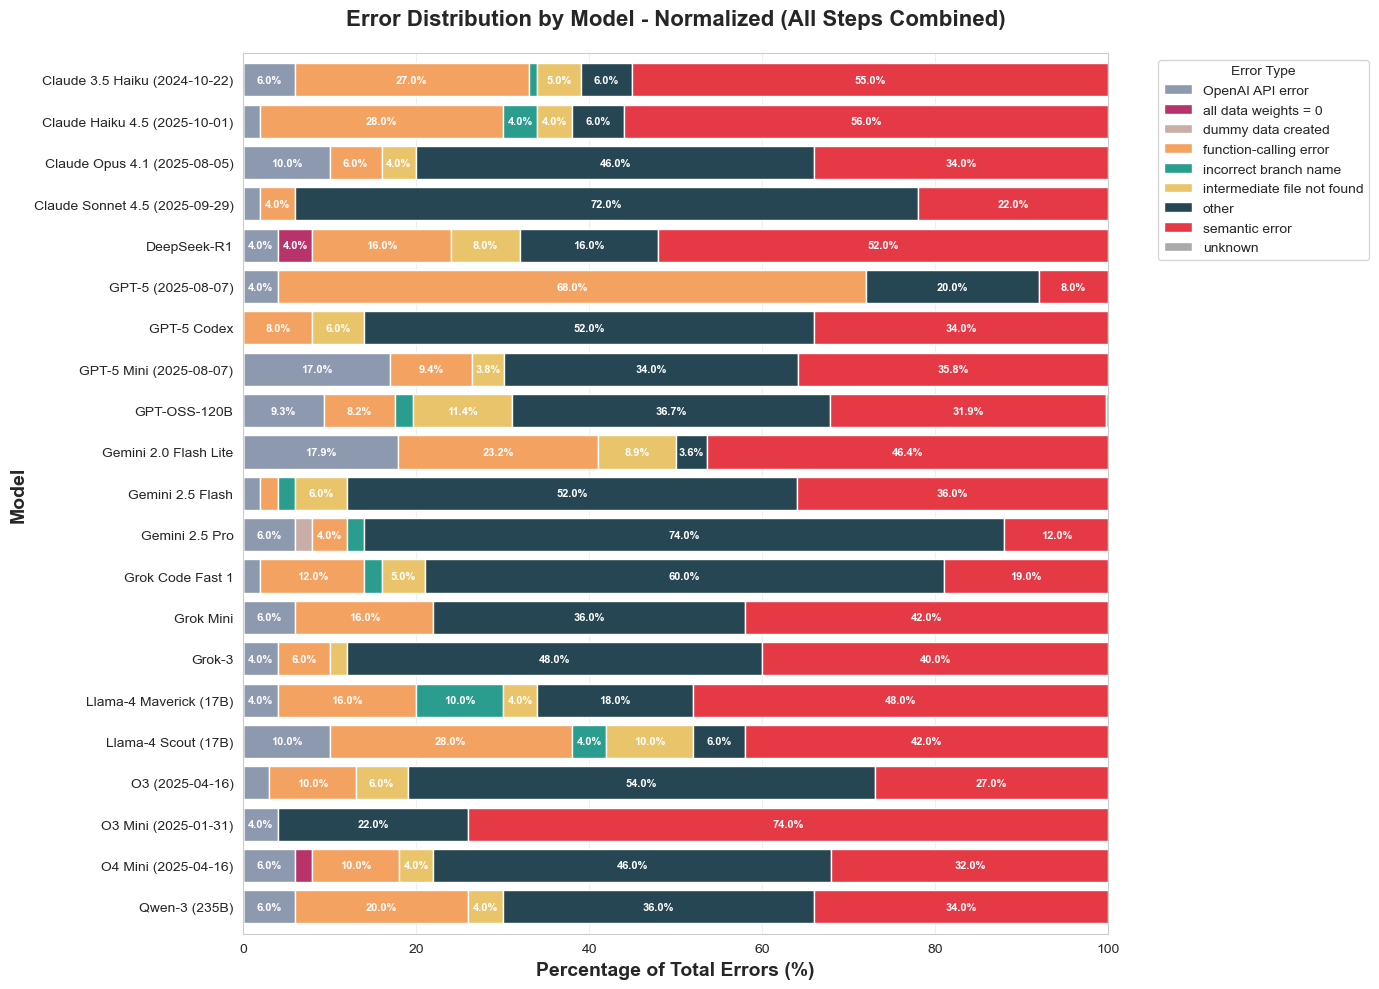

In [19]:
# Create a pivot table for stacked bar chart
error_pivot = error_counts.pivot(index='model', columns='error_type', values='count').fillna(0)

# Normalize to percentages (each row sums to 100%)
error_pivot_pct = error_pivot.div(error_pivot.sum(axis=1), axis=0) * 100

# Define custom order (matching the reference PDF, reversed)
model_order = [
    'Qwen-3 (235B)',
    'O4 Mini (2025-04-16)',
    'O3 Mini (2025-01-31)',
    'O3 (2025-04-16)',
    'Llama-4 Scout (17B)',
    'Llama-4 Maverick (17B)',
    'Grok-3',
    'Grok Mini',
    'Grok Code Fast 1',
    'Gemini 2.5 Pro',
    'Gemini 2.5 Flash',
    'Gemini 2.0 Flash Lite',
    'GPT-OSS-120B',
    'GPT-5 Mini (2025-08-07)',
    'GPT-5 Codex',
    'GPT-5 (2025-08-07)',
    'DeepSeek-R1',
    'Claude Sonnet 4.5 (2025-09-29)',
    'Claude Opus 4.1 (2025-08-05)',
    'Claude Haiku 4.5 (2025-10-01)',
    'Claude 3.5 Haiku (2024-10-22)',
]

# Reindex to match the custom order (only include models that exist in data)
existing_models = [m for m in model_order if m in error_pivot_pct.index]
error_pivot_pct = error_pivot_pct.reindex(existing_models)

# Define colors for error types (updated to match normalized names)
error_colors = {
    'semantic error': '#E63946',           # Red
    'function-calling error': '#F4A261',   # Orange
    'intermediate file not found': '#E9C46A',  # Yellow
    'incorrect branch name': '#2A9D8F',    # Teal
    'other': '#264653',                     # Dark blue
    'OpenAI API error': '#8D99AE',         # Gray (was 'uncategorized')
    'all data weights = 0': '#B8336A',     # Pink (simplified name)
    'dummy data created': '#C9ADA7',       # Light brown
    'unknown': '#AAAAAA',                  # Light gray
}

# Create figure
fig, ax = plt.subplots(figsize=(14, max(10, len(error_pivot_pct) * 0.4)))

# Create stacked bar chart with percentages
error_pivot_pct.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=[error_colors.get(col, '#cccccc') for col in error_pivot_pct.columns],
    width=0.8
)

# Add percentage labels inside the bars
for i, model in enumerate(error_pivot_pct.index):
    cumulative = 0
    for col in error_pivot_pct.columns:
        value = error_pivot_pct.loc[model, col]
        if value > 3:  # Only show label if segment is larger than 3%
            ax.text(cumulative + value/2, i, f'{value:.1f}%', 
                   ha='center', va='center', fontsize=8, fontweight='bold', color='white')
        cumulative += value

# Customize
ax.set_xlabel('Percentage of Total Errors (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Model', fontsize=14, fontweight='bold')
ax.set_title('Error Distribution by Model - Normalized (All Steps Combined)', fontsize=16, fontweight='bold', pad=20)

# Update legend to use normalized error names
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/error_distribution_by_model.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/error_distribution_by_model.pdf', bbox_inches='tight')
plt.show()

## Visualization 2: Heatmap - Error Types vs Models

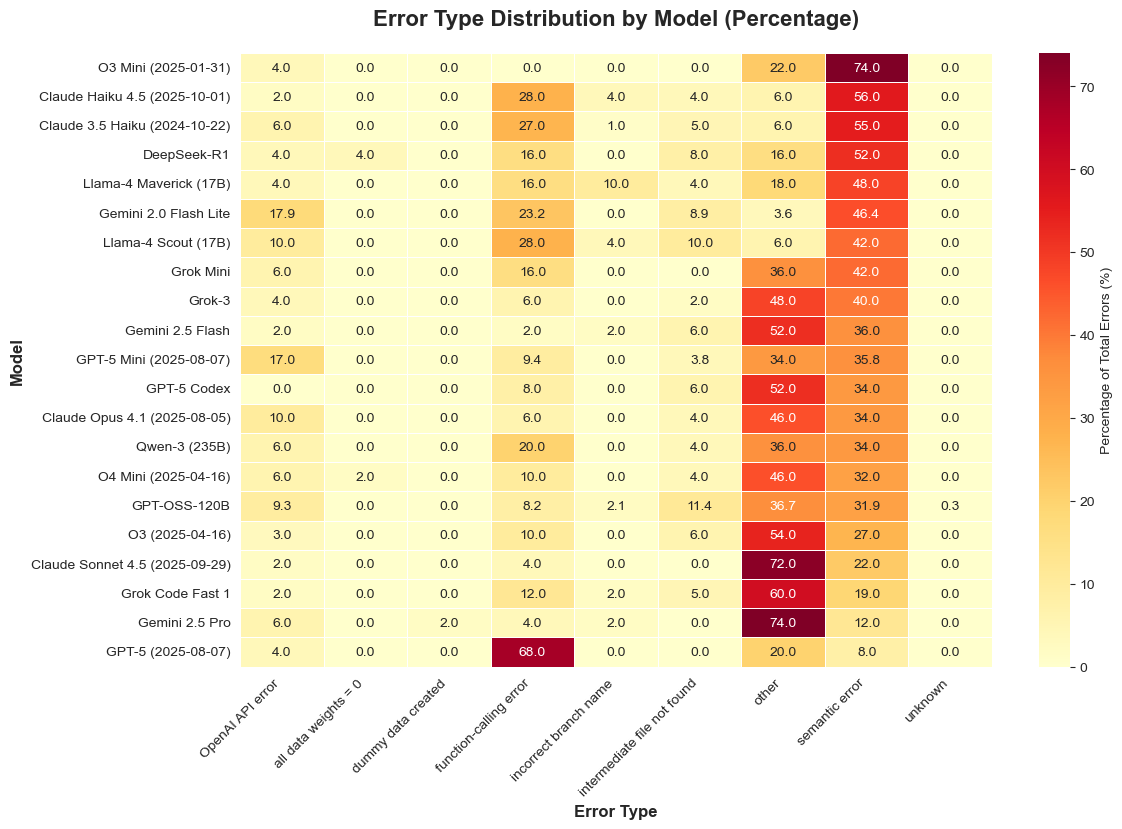

In [20]:
# Create normalized heatmap (percentage of total errors for each model)
error_pivot_pct = error_pivot.div(error_pivot.sum(axis=1), axis=0) * 100

# Sort by most common error type
error_pivot_pct = error_pivot_pct.sort_values('semantic error', ascending=False)

fig, ax = plt.subplots(figsize=(12, max(8, len(error_pivot_pct) * 0.4)))

sns.heatmap(
    error_pivot_pct,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Percentage of Total Errors (%)'},
    linewidths=0.5,
    ax=ax
)

ax.set_title('Error Type Distribution by Model (Percentage)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Error Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/error_heatmap_by_model.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/error_heatmap_by_model.pdf', bbox_inches='tight')
plt.show()

## Visualization 3: Error Rate by Model (with breakdown)

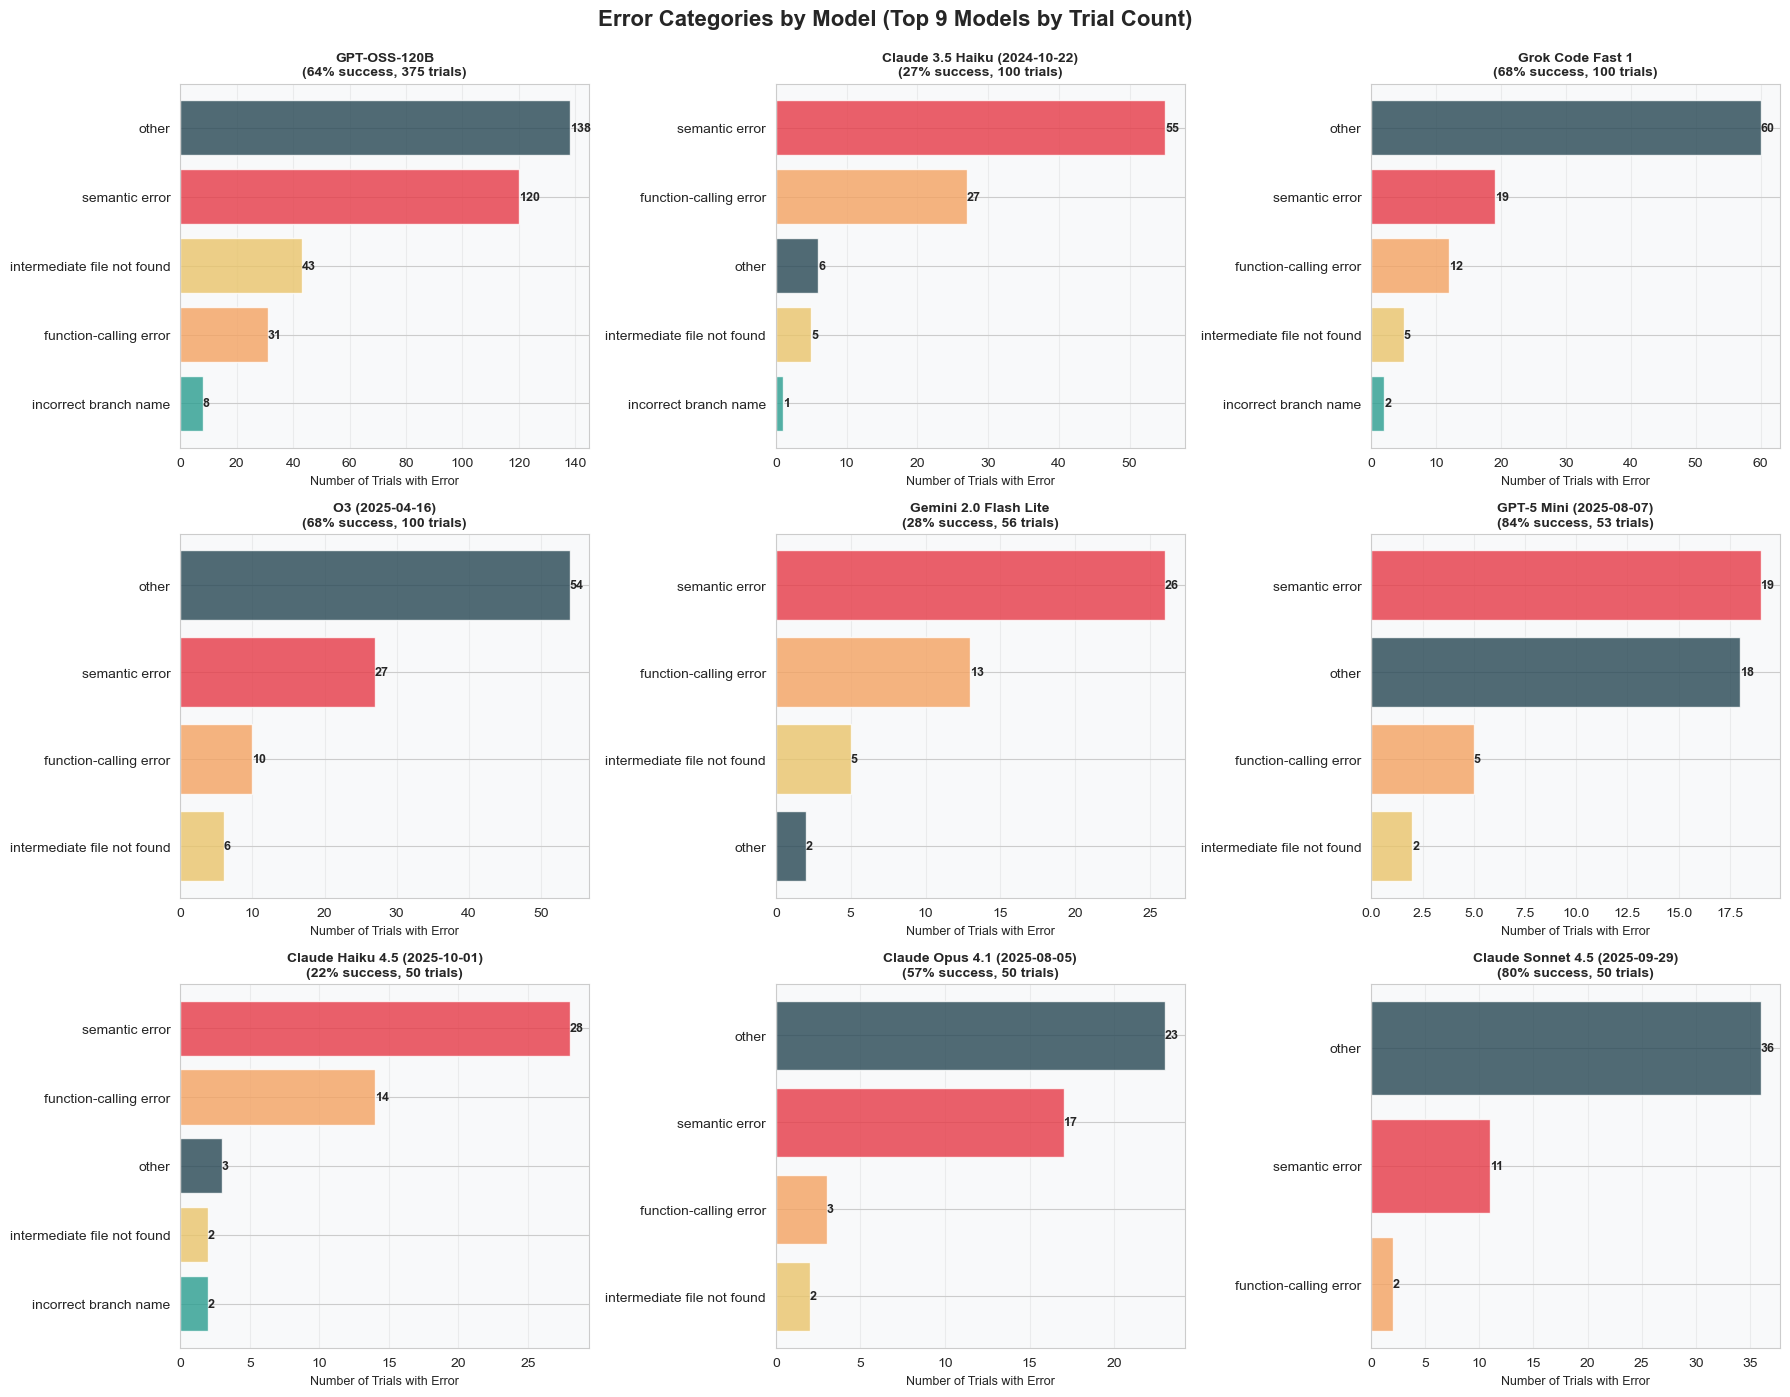

In [21]:
# Calculate error rates
model_error_stats = []

for model in df['model'].unique():
    model_df = df[df['model'] == model]
    total = len(model_df)
    
    # Count each error type
    model_errors = df_errors[df_errors['model'] == model]
    
    for error_type in df_errors['error_type'].unique():
        # Count trials with this error (not total occurrences)
        trials_with_error = len(model_df[model_df['error_list'].apply(lambda x: error_type in x)])
        
        if trials_with_error > 0:
            model_error_stats.append({
                'model': model,
                'error_type': error_type,
                'count': trials_with_error,
                'percentage': trials_with_error / total * 100
            })

error_stats_df = pd.DataFrame(model_error_stats)

# Create faceted bar plots for top models
top_models = model_stats.nlargest(9, 'total_trials')['model'].values

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, model in enumerate(top_models):
    ax = axes[idx]
    
    model_data = error_stats_df[error_stats_df['model'] == model].copy()
    
    if len(model_data) > 0:
        model_data = model_data.sort_values('count', ascending=True)
        
        colors = [error_colors.get(et, '#cccccc') for et in model_data['error_type']]
        
        bars = ax.barh(model_data['error_type'], model_data['count'], color=colors, alpha=0.8)
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                   f'{int(width)}',
                   ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Add model stats
    model_info = model_stats[model_stats['model'] == model].iloc[0]
    title = f"{model}\n({int(model_info['success_rate'])}% success, {int(model_info['total_trials'])} trials)"
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel('Number of Trials with Error', fontsize=9)
    ax.grid(axis='x', alpha=0.3)
    ax.set_facecolor('#F8F9FA')

fig.suptitle('Error Categories by Model (Top 9 Models by Trial Count)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('plots/error_categories_top_models.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/error_categories_top_models.pdf', bbox_inches='tight')
plt.show()

## Visualization 4: Error Trends Across Steps

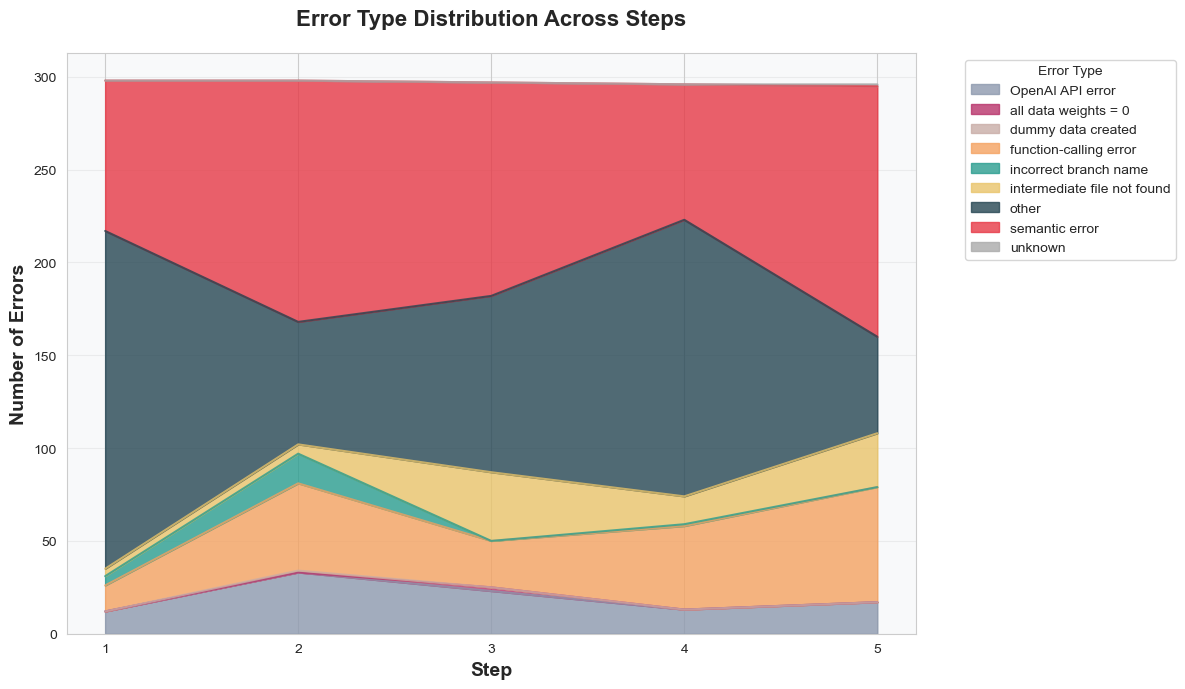

In [22]:
# Analyze errors by step
step_error_counts = df_errors.groupby(['step', 'error_type']).size().reset_index(name='count')

# Create stacked area chart
error_by_step = step_error_counts.pivot(index='step', columns='error_type', values='count').fillna(0)

fig, ax = plt.subplots(figsize=(12, 7))

# Create stacked area plot
error_by_step.plot(
    kind='area',
    stacked=True,
    ax=ax,
    color=[error_colors.get(col, '#cccccc') for col in error_by_step.columns],
    alpha=0.8
)

ax.set_xlabel('Step', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Errors', fontsize=14, fontweight='bold')
ax.set_title('Error Type Distribution Across Steps', fontsize=16, fontweight='bold', pad=20)
ax.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis='y', alpha=0.3)
ax.set_facecolor('#F8F9FA')

plt.tight_layout()
plt.savefig('plots/errors_by_step.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/errors_by_step.pdf', bbox_inches='tight')
plt.show()

## Summary Statistics Table

In [ ]:
# Create comprehensive summary table
summary_data = []

for model in df['model'].unique():
    model_df = df[df['model'] == model]
    model_errors = df_errors[df_errors['model'] == model]
    
    total = len(model_df)
    failed = len(model_df[model_df['success'] == False])
    success_rate = (total - failed) / total * 100
    
    # Most common error
    if len(model_errors) > 0:
        error_type_counts = model_errors['error_type'].value_counts()
        most_common_error = error_type_counts.index[0]
        most_common_count = error_type_counts.values[0]
    else:
        most_common_error = 'None'
        most_common_count = 0
    
    summary_data.append({
        'Model': model,
        'Total Trials': total,
        'Failed Trials': failed,
        'Success Rate (%)': f"{success_rate:.1f}",
        'Most Common Error': most_common_error,
        'Count': most_common_count
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Success Rate (%)', ascending=False)

print("\n" + "="*100)
print("MODEL ERROR SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv('plots/model_error_summary.csv', index=False)
print("\nSummary saved to: plots/model_error_summary.csv")